*imports*

In [ ]:
'''
TODO:
dependincies smokiing vs Hx
compare age to savrity of cancer - Stage
age-smoking
Outliers: test features combined with Agehttps://www.kaggle.com/code/rafjaa/dealing-with-very-small-datasets/notebook
compare gender on each feature
add plot from paper - done
read paper
check which categries can be converted to numbers (like stage) - should use one hot encoding
deal which classes that have low numbers of participants (like stage >3)
'''

'\nTODO:\ndependincies smokiing vs Hx\ncompare age to savrity of cancer - Stage\nage-smoking\nOutliers: test features combined with Agehttps://www.kaggle.com/code/rafjaa/dealing-with-very-small-datasets/notebook\ncompare gender on each feature\nadd plot from paper - done\nread paper\ncheck which categries can be converted to numbers (like stage) - should use one hot encoding\ndeal which classes that have low numbers of participants (like stage >3)\n'

In [ ]:
#data processing
import pandas as pd
import numpy as np
import xgboost as xgb
#data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Machine learning library
import sklearn
import os
import warnings
warnings.filterwarnings("ignore")


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
shared_folder_path = '/content/drive/My Drive/tables_data'
os.chdir(shared_folder_path)
df = pd.read_csv('Thyroid_Dataset.csv')

Mounted at /content/drive


                                                                      Data Analysis And Visualization

In [ ]:
df.head(3)

,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,F,No,No,No,Euthyroid,Single nodular goiter-left,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,No
1,34,F,No,Yes,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
2,30,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No


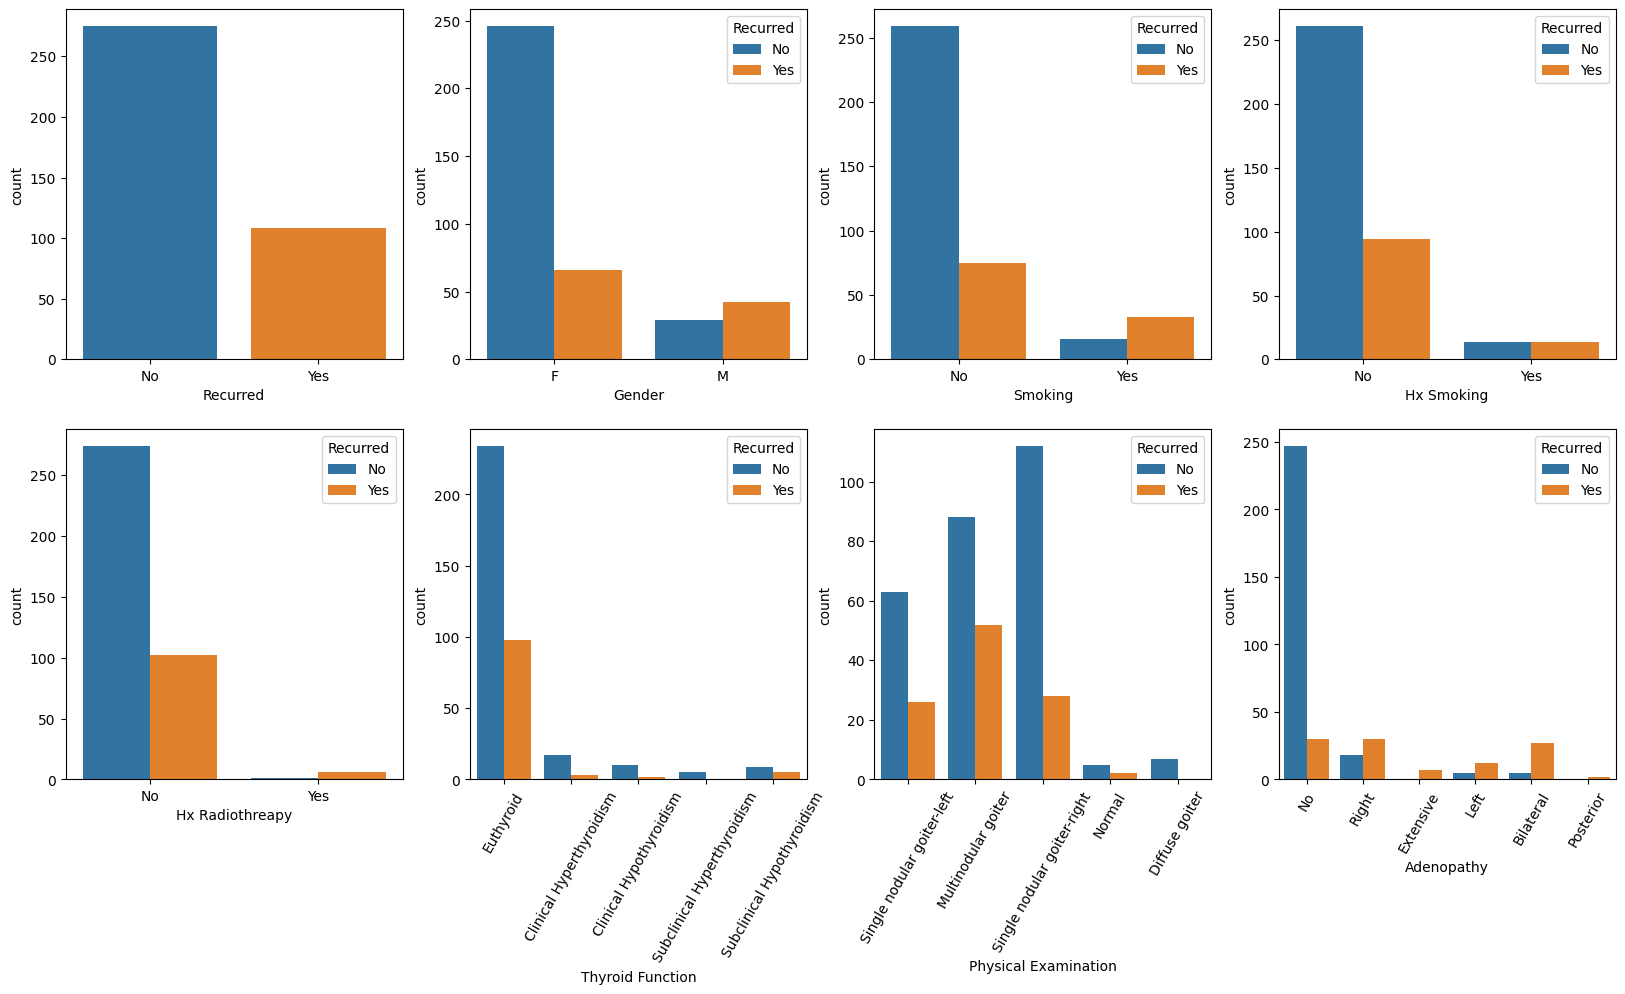

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(241)
sns.countplot(df, x='Recurred', hue='Recurred')
plt.subplot(242)
sns.countplot(df, x='Gender', hue='Recurred')
plt.subplot(243)
sns.countplot(df, x='Smoking', hue='Recurred')
plt.subplot(244)
sns.countplot(df, x='Hx Smoking', hue='Recurred')
plt.subplot(245)
sns.countplot(df, x='Hx Radiothreapy', hue ='Recurred')
plt.subplot(246)
sns.countplot(df, x='Thyroid Function', hue='Recurred')
plt.xticks(rotation=60)
plt.subplot(247)
sns.countplot(df, x='Physical Examination', hue='Recurred')
plt.xticks(rotation=60)
plt.subplot(248)
sns.countplot(df, x='Adenopathy', hue='Recurred')
plt.xticks(rotation=60)
plt.show()

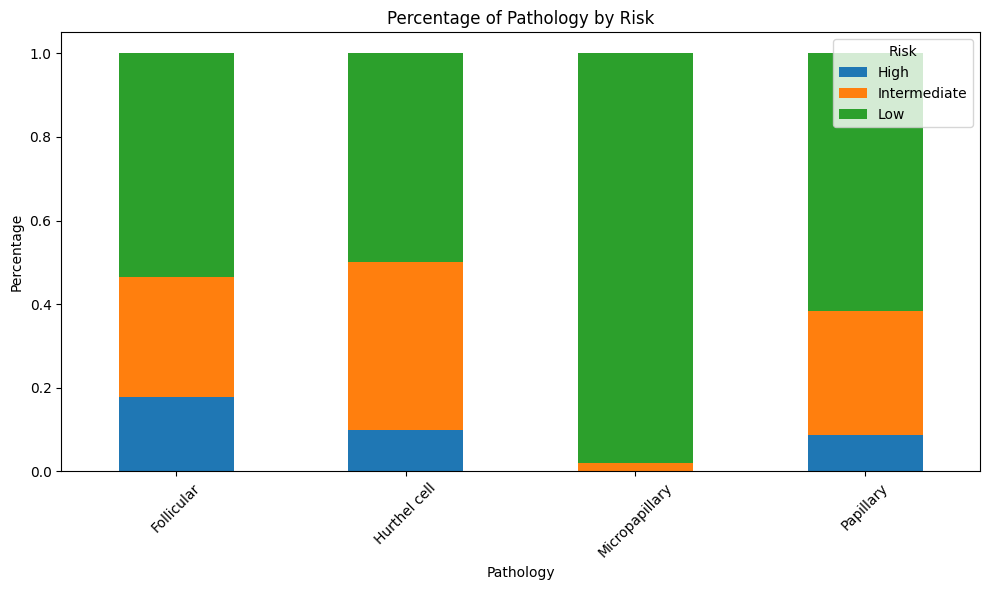

In [ ]:
# Convert data to DataFrame
df = pd.DataFrame(df)

# Calculate percentages
total_counts = df.groupby('Pathology').size()
grouped_counts = df.groupby(['Pathology', 'Risk']).size()
percentages = (grouped_counts / total_counts).unstack(fill_value=0)

# Plot
percentages.plot(kind='bar', stacked=True, figsize=(10, 6))

# Add labels and title
plt.title('Percentage of Pathology by Risk')
plt.xlabel('Pathology')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Risk')
plt.tight_layout()
plt.show()

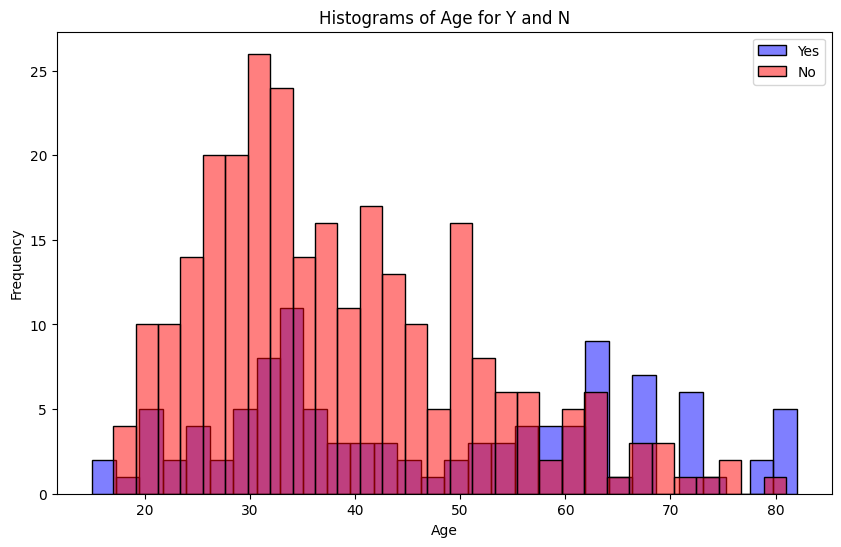

In [ ]:

df_y = df[df['Recurred'] == 'Yes']
df_n = df[df['Recurred'] == 'No']

plt.figure(figsize=(10, 6))
sns.histplot(df_y['Age'], color='blue', label='Yes', bins=30, alpha=0.5)
sns.histplot(df_n['Age'], color='red', label='No', bins=30, alpha=0.5)
plt.legend()
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histograms of Age for Y and N')
plt.show()

In [ ]:
import curses

def draw_histogram(stdscr, data):
    height, width = stdscr.getmaxyx()
    max_freq = max(data.values())
    bar_width = width - 15

    stdscr.addstr(0, 0, "Histogram")
    for i, (label, freq) in enumerate(data.items(), start=2):
        bar_size = int(bar_width * (freq / max_freq))
        stdscr.addstr(i, 2, f"{label}:")
        stdscr.addstr(i, 10, "#" * bar_size)

def main(stdscr):

    data = {'Y': 20, 'N': 10}  # Example data, replace with your actual data
    curses.curs_set(0)
    draw_histogram(stdscr, data)
    stdscr.refresh()
    stdscr.getch()

curses.wrapper(main)

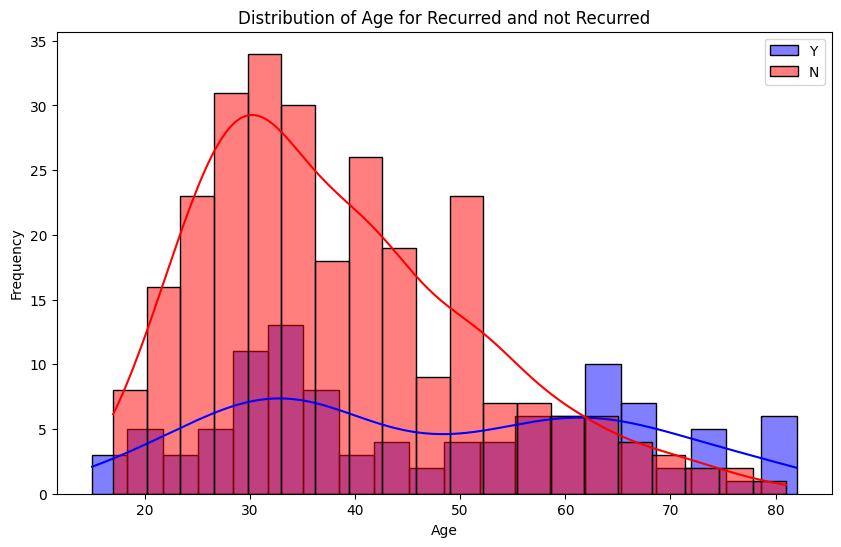

In [ ]:
plt.figure(figsize=(10, 6))

# Plot for 'Y' label
sns.histplot(df[df['Recurred'] == 'Yes']['Age'], bins=20, kde=True, color='blue', label='Y')

# Plot for 'N' label
sns.histplot(df[df['Recurred'] == 'No']['Age'], bins=20, kde=True, color='red', label='N')

plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age for Recurred and not Recurred')
plt.legend()
plt.show()


Insight: from those results we can assume that high age might indicated on high probablity for reccuring

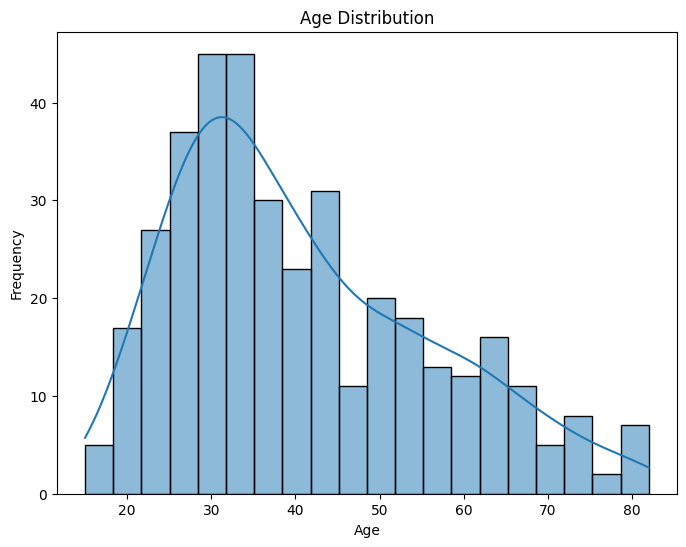

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(df['Age'], bins=20, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

Hx smoking vs smoking


H0: there's high correltion between 'Hx Smoking' and 'Smoking' so that we can use only of of those features

In [ ]:
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(df['Hx Smoking'], df['Recurred'])
chi2, p_value, _, _ = chi2_contingency(contingency_table)
print("Chi-square value:", chi2)
print("P-value:", p_value)


Chi-square value: 5.977474414669837
P-value: 0.014489737063609615


In [ ]:
# Subset of individuals who smoke and have recurred
df_smoking_recurred = df[(df['Smoking'] == 'Yes') & (df['Recurred'] == 'Yes')]

# Subset of individuals with history of smoking and have recurred
df_hx_smoking_recurred = df[(df['Hx Smoking'] == 'Yes') & (df['Recurred'] == 'Yes')]

# Contingency table for Smoking-Yes and Recurred-Yes vs Hx Smoking-Yes and Recurred-Yes
contingency_table = pd.DataFrame({
    'Smoking-Yes Recurred-Yes': [len(df_smoking_recurred)],
    'Hx Smoking-Yes Recurred-Yes': [len(df_hx_smoking_recurred)]
})

# Chi-square test
chi2, p_value, _, _ = chi2_contingency(contingency_table)

print("Chi-square value:", chi2)
print("P-value:", p_value)

Chi-square value: 0.0
P-value: 1.0


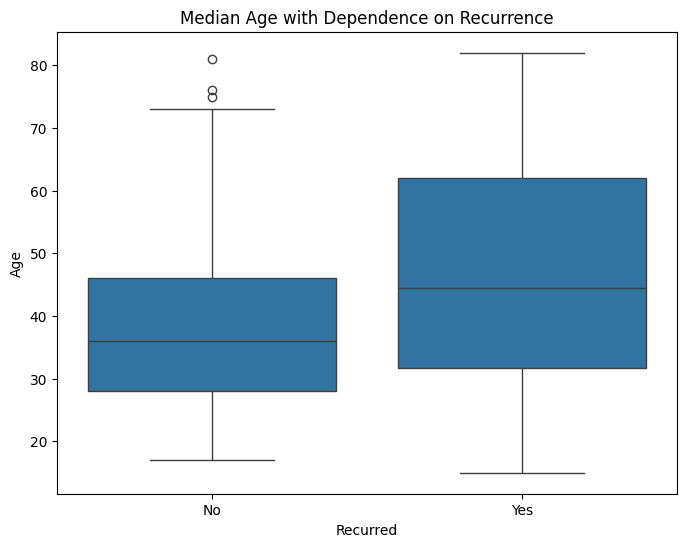

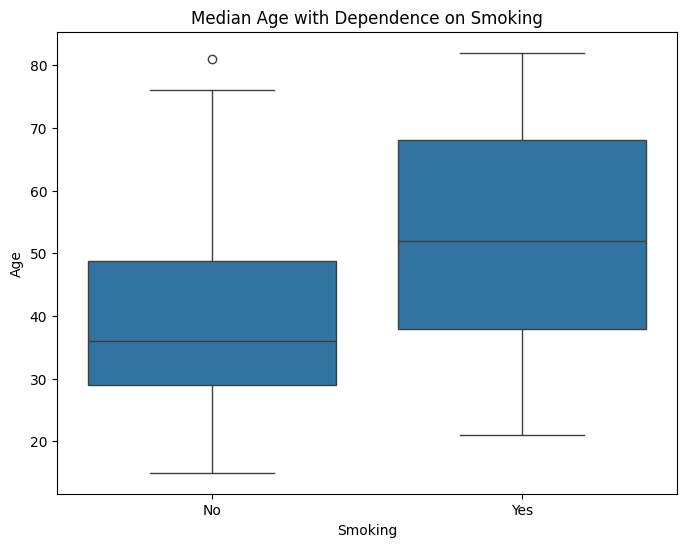

In [ ]:
# # Assuming df is your DataFrame
# num_smoking_yes_hx_smoking_no = df[(df['Smoking'] == 'Yes') & (df['Hx Smoking'] == 'No')].shape[0]
# print("Number of individuals with Smoking='Yes' and Hx Smoking='No':", num_smoking_yes_hx_smoking_no)

# Convert data to DataFrame
df = pd.DataFrame(df)

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Recurred', y='Age', data=df)

# Add labels and title
plt.title('Median Age with Dependence on Recurrence')
plt.xlabel('Recurred')
plt.ylabel('Age')

# Show plot
plt.show()

# Convert data to DataFrame
df = pd.DataFrame(df)

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Smoking', y='Age', data=df)

# Add labels and title
plt.title('Median Age with Dependence on Smoking')
plt.xlabel('Smoking')
plt.ylabel('Age')

# Show plot
plt.show()

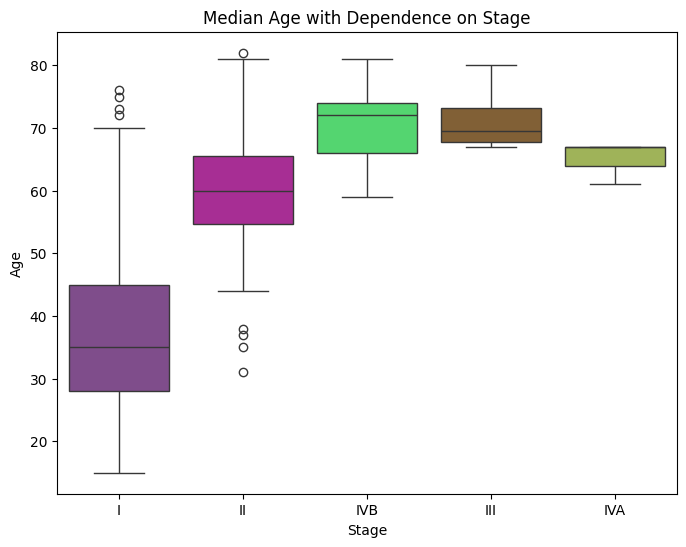

Number of rows where Stage is IVb: 333
Number of rows where Stage is IVb and Recurred is Yes: 65


In [ ]:
# Convert data to DataFrame
df = pd.DataFrame(df)

# Get unique stages
stages = df['Stage'].unique()

# Generate random colors
color_map = {stage: np.random.rand(3,) for stage in stages}

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Stage', y='Age', data=df, palette=color_map)

# Add labels and title
plt.title('Median Age with Dependence on Stage')
plt.xlabel('Stage')
plt.ylabel('Age')

# Show plot
plt.show()

# Convert data to DataFrame
df = pd.DataFrame(df)
stage_IVb_df = df[df['Stage'] == 'I']

# Count the number of rows where Recurred is Yes
recurred_yes_count = stage_IVb_df[stage_IVb_df['Recurred'] == 'Yes'].shape[0]

# Total number of rows where Stage is IVb
total_IVb_count = stage_IVb_df.shape[0]

print("Number of rows where Stage is IVb:", total_IVb_count)
print("Number of rows where Stage is IVb and Recurred is Yes:", recurred_yes_count)